In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

path_train = "C:/Users/Kosta/OneDrive/Desktop/Data_Science/WBS_rest/solutions_notebooks/mushrooms_train.csv"
# load data
mushrooms_train = (
    pd.read_csv(path_train)
    # .drop(columns='poisonous')
    .filter(
        ['Id','cap.shape', 'cap.color', 'stalk.color.above.ring',
        'stalk.color.below.ring', 'bruises', 'population','poisonous'])
    .set_index('Id')
    )
# y_train = train['poisonous']
mushrooms_train.duplicated().sum() / mushrooms_train.shape[0]

0.9390675488536698

94% of the data is duplicated, let's drop it all the innecessary information!

Train

    accuracy: 0.9116161616161617
    roc_auc: 0.9059534081104399
    confusion matrix: 
    
           edible  poisonous
edible        227         17
poisonous      18        134


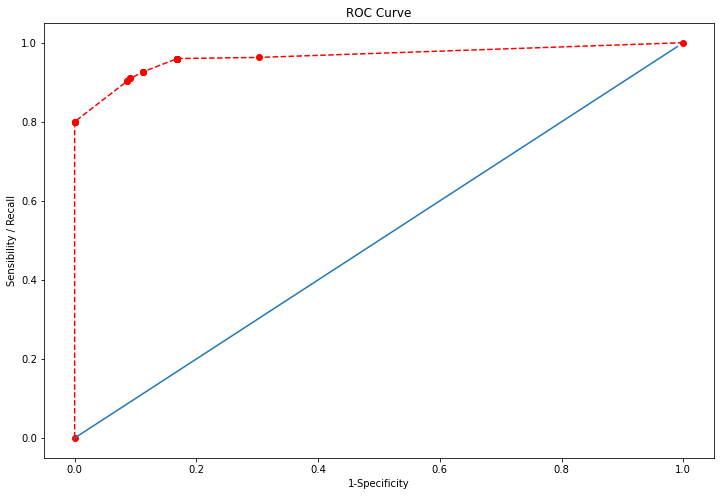

In [2]:
mushrooms_train.drop_duplicates(inplace=True)

# predictors and predicted
X_train = mushrooms_train.drop(columns='poisonous')
y_train = mushrooms_train['poisonous']

# preprocess
ohe = OneHotEncoder(sparse=False)
X_train_enc = ohe.fit_transform(X_train)

# error evaluation
def error_metrics(y_true, y_pred, model, data): 
    print(f"""
    accuracy: {accuracy_score(y_true, y_pred)}
    roc_auc: {roc_auc_score(y_true, y_pred)}
    confusion matrix: 
    """)
    cols_names = ['edible','poisonous']
    print(
        pd.DataFrame(
            confusion_matrix(y_true, y_pred), 
            columns=cols_names, 
            index=cols_names)
        )
    
    probs = model.predict_proba(data)
    prob = probs[:,1]
    prob_df = pd.DataFrame(prob)

    thresholds = [i/100 for i in range(5, 100, 5)]
    sensitivities = [1]
    specifities_1 = [1]

    for t in thresholds:
        prob_df["prediction"] = np.where(prob_df[0]>=t, 1, 0)
        prob_df["actual"] = list(y_true)

        conf_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
        TP=conf_matrix[0][0]
        TN=conf_matrix[1][1]
        FP=conf_matrix[0][1]
        FN=conf_matrix[1][0]
        
        sens = TP/(TP+FN)
        sensitivities.append(sens)
        spc_1 = 1 - TN/(TN+FP)
        specifities_1.append(spc_1)

    sensitivities.append(0)
    specifities_1.append(0)

    import matplotlib.pyplot as plt
    plt.subplots(figsize=(12,8))
    plt.plot(specifities_1, sensitivities, marker="o", linestyle="--", color="r")
    x=[i*0.01 for i in range(100)]
    y=[i*0.01 for i in range(100)]
    plt.plot(x,y)
    plt.xlabel("1-Specificity")
    plt.ylabel("Sensibility / Recall")
    plt.title("ROC Curve")
    plt.show()

# tree train
tree = DecisionTreeClassifier(max_depth=4)
tree = tree.fit(X_train_enc, y_train)
print('Train')
error_metrics(y_train, tree.predict(X_train_enc), tree, X_train_enc)

Train

    accuracy: 0.8838383838383839
    roc_auc: 0.8734900776531493
    confusion matrix: 
    
           edible  poisonous
edible        224         20
poisonous      26        126


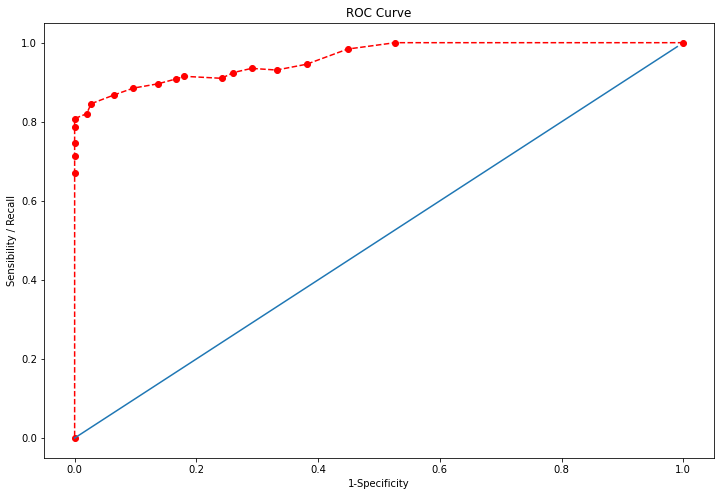

In [3]:
# model train
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=9999)
log_reg.fit(X_train_enc, y_train)
print('Train')
error_metrics(y_train, log_reg.predict(X_train_enc), log_reg, X_train_enc)

Train

    accuracy: 0.9393939393939394
    roc_auc: 0.9346958584987058
    confusion matrix: 
    
           edible  poisonous
edible        233         11
poisonous      13        139


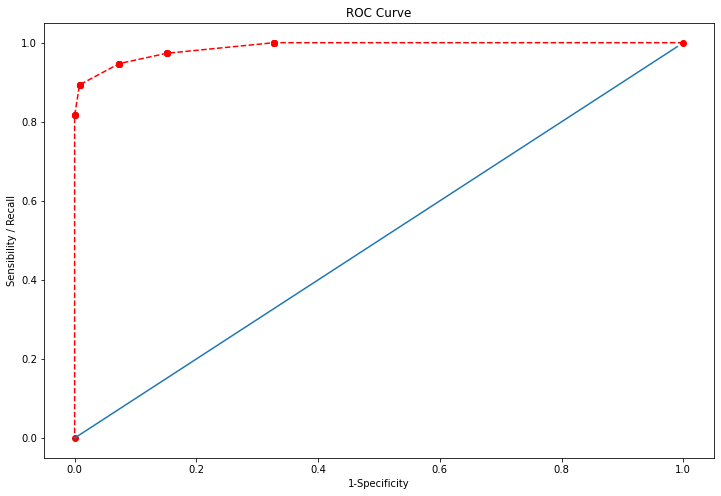

In [4]:
# model train
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_enc, y_train)
print('Train')
error_metrics(y_train, knn.predict(X_train_enc), knn, X_train_enc)

## 2 ways to solve our problem:

### Define a threshold



    accuracy: 0.8013698630136986
    roc_auc: 0.8217213114754098
    confusion matrix: 
    
           edible  poisonous
edible        157         87
poisonous       0        194


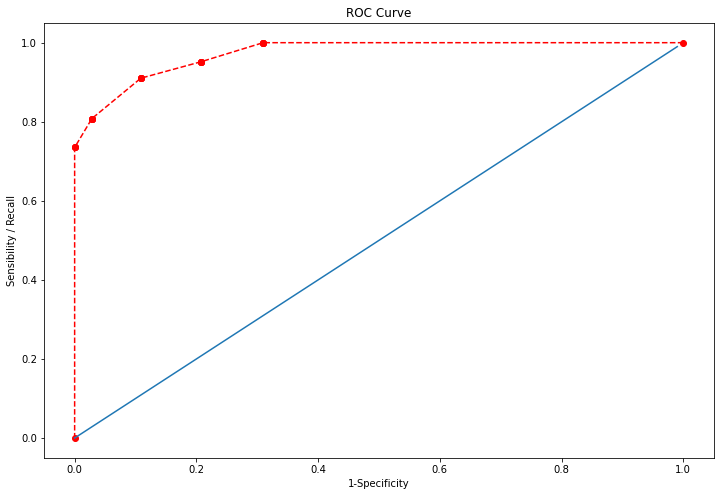

In [27]:
def cautious_model(poisinous_prob): 
    if poisinous_prob > 0: 
        return 1
    else: 
        return 0

def preds_review(model, data): 
    prob_df = (
        pd.DataFrame(
            model.predict_proba(data), 
            columns=['edible','poisonous']
        ))
    preds = [cautious_model(pois_prob) for pois_prob in prob_df['poisonous']]
    return preds

y_pred = preds_review(knn, X_train_enc)
error_metrics(y_train, y_pred, knn, X_train_enc)

### Oversample our misspredicted observations

In [28]:
# find out the problematic mushrooms
problematic_mushrooms = (
X_train
    .assign(
        poisonous = y_train, 
        pred_pois = knn.predict(X_train_enc)
        )
    # detect the mushrooms should be poisonous but are misspredicted
    .query("poisonous == 1 & pred_pois == 0")
)
problematic_mushrooms

,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population,poisonous,pred_pois
Id,,,,,,,,
4858,f,n,w,w,True,s,1,0
3787,x,b,w,w,True,v,1,0
4389,x,g,w,w,True,s,1,0
7252,f,n,w,w,False,v,1,0
1153,f,b,w,w,True,v,1,0
1512,f,p,w,w,True,v,1,0
7500,x,n,w,w,True,v,1,0
7735,f,g,w,w,True,v,1,0
2112,k,w,w,w,True,c,1,0


In [8]:
new_train = pd.concat([mushrooms_train, problematic_mushrooms.drop(columns='pred_pois')])
new_train

,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population,poisonous
Id,,,,,,,
6573,k,e,w,w,False,v,1
4426,f,e,p,w,True,y,0
7018,b,w,w,w,False,s,0
5789,k,g,w,w,False,n,0
6187,f,n,p,g,True,v,0
...,...,...,...,...,...,...,...
2501,x,g,w,w,True,v,1
2815,x,n,w,n,False,v,1
2583,x,w,w,w,False,s,1



    accuracy: 0.9292237442922374
    roc_auc: 0.9364754098360656
    confusion matrix: 
    
           edible  poisonous
edible        213         31
poisonous       0        194


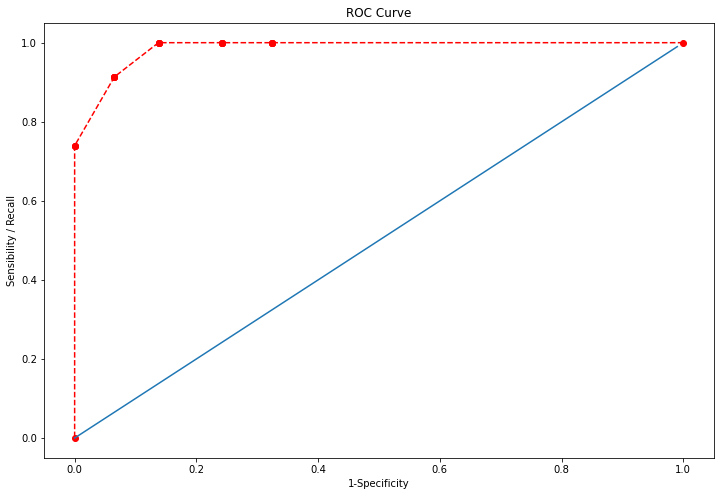

In [29]:
# predictors and predicted
X_train = new_train.drop(columns='poisonous')
y_train = new_train['poisonous']

# preprocess
X_train_enc = ohe.transform(X_train)

# train model
knn.fit(X_train_enc, y_train)
error_metrics(y_train, knn.predict(X_train_enc), knn, X_train_enc)

Number of problematic mushrooms 11

    accuracy: 0.9385749385749386
    roc_auc: 0.9324776224479534
    confusion matrix: 
    
           edible  poisonous
edible        235          9
poisonous      16        147


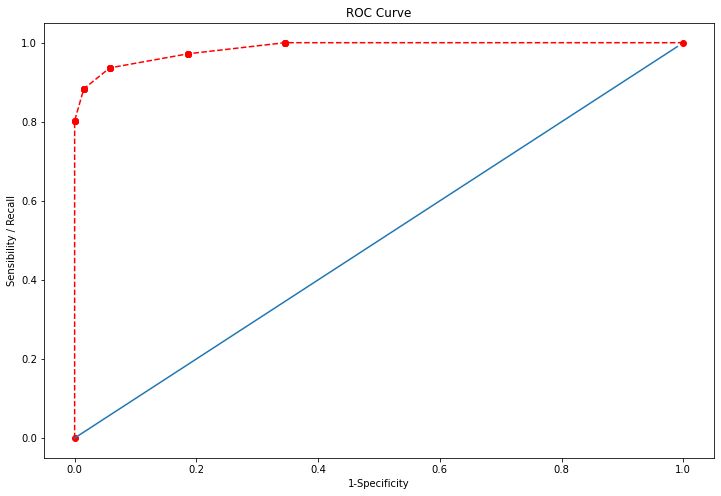

Number of problematic mushrooms 16

    accuracy: 0.9243498817966903
    roc_auc: 0.9262409561315138
    confusion matrix: 
    
           edible  poisonous
edible        223         21
poisonous      11        168


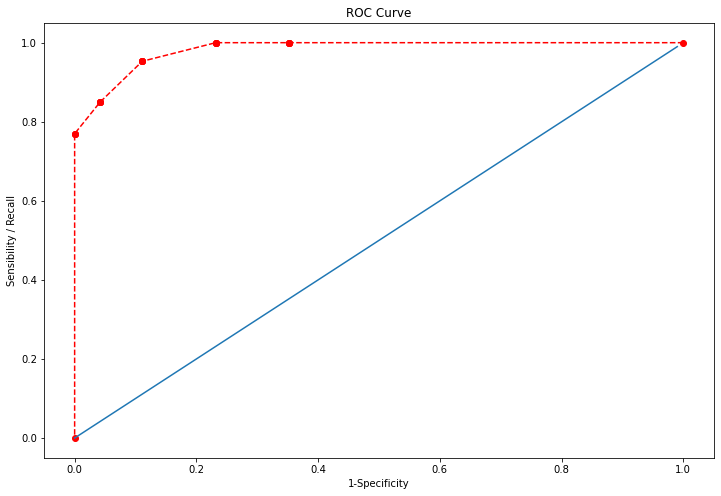

Number of problematic mushrooms 11

    accuracy: 0.9331797235023042
    roc_auc: 0.9382441760138049
    confusion matrix: 
    
           edible  poisonous
edible        219         25
poisonous       4        186


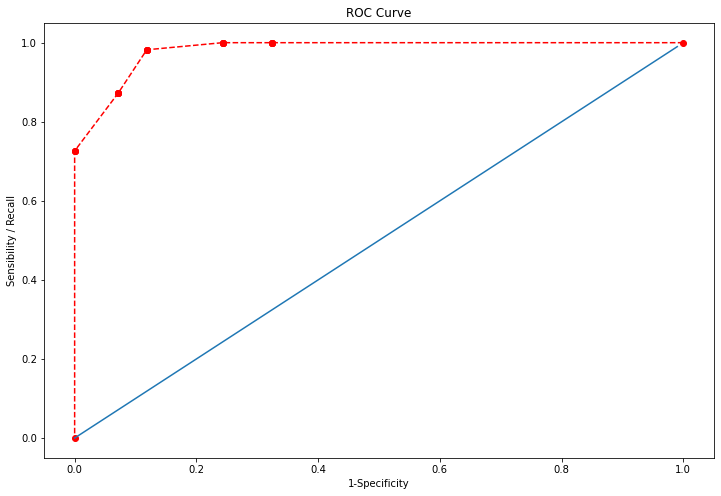

Number of problematic mushrooms 4

    accuracy: 0.9292237442922374
    roc_auc: 0.9364754098360656
    confusion matrix: 
    
           edible  poisonous
edible        213         31
poisonous       0        194


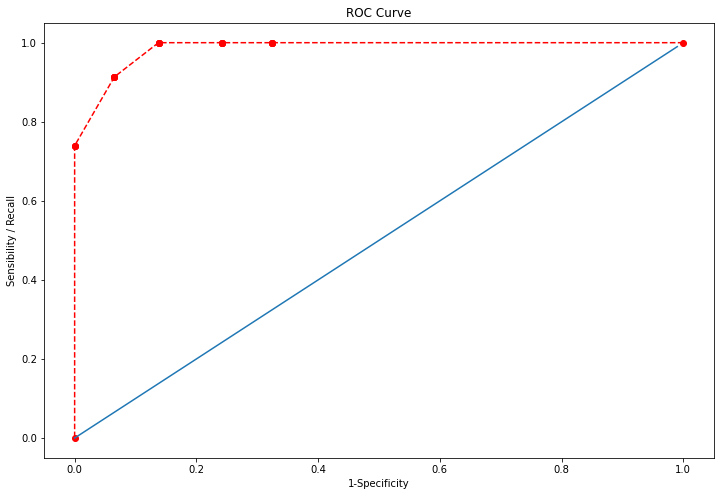

In [11]:
# find out the problematic mushrooms

def find_problematic_mushrooms(X_train, y_train, model):

    problematic_mushrooms = (
    X_train
        .assign(
            poisonous = y_train, 
            pred_pois = model.predict(X_train_enc)
            )
        # detect the mushrooms should be poisonous but are misspredicted
        .query("poisonous == 1 & pred_pois == 0")
    )
    return problematic_mushrooms

new_train = mushrooms_train.copy()
oversampled_knn = knn
iterations = 0
while True: 
    problematic_mushrooms = find_problematic_mushrooms(X_train, y_train, oversampled_knn)
    if problematic_mushrooms.shape[0] == 0: 
        break
    else: 
        print(f"Number of problematic mushrooms {problematic_mushrooms.shape[0]}")
    new_train = pd.concat([new_train, problematic_mushrooms.drop(columns='pred_pois')])
    # predictors and predicted
    X_train = new_train.drop(columns='poisonous')
    y_train = new_train['poisonous']

    # preprocess
    X_train_enc = ohe.transform(X_train)

    # train model
    oversampled_knn = KNeighborsClassifier()
    oversampled_knn.fit(X_train_enc, y_train)
    error_metrics(y_train, oversampled_knn.predict(X_train_enc), oversampled_knn, X_train_enc)
    iterations += 1

# Test our model

In [17]:
path_test = "C:/Users/Kosta/OneDrive/Desktop/Data_Science/WBS_rest/solutions_notebooks/mushrooms_test.csv"
path_results = "C:/Users/Kosta/OneDrive/Desktop/Data_Science/WBS_rest/solutions_notebooks/mushrooms_results.csv"
mushrooms_test = pd.read_csv(path_test)
mushrooms_results = pd.read_csv(path_results)
mushrooms_test.set_index('Id', inplace=True)

mushrooms_results.drop(columns='Id', inplace=True)
X_test_enc = ohe.transform(mushrooms_test)

## Cautious model

In [19]:
y_pred = preds_review(knn, X_test_enc)
cautious_mod_submission = pd.DataFrame({
    'Id':mushrooms_test.index, 
    'poisonous':y_pred
})
confusion_matrix(results['poisonous'], y_pred)

array([[221, 563],
       [234, 607]], dtype=int64)

In [20]:
cautious_mod_submission.to_csv('cautious_submission.csv', index=False)

## Oversampled model

In [21]:
y_pred = oversampled_knn.predict(X_test_enc)
oversampled_mod_submission = pd.DataFrame({
    'Id':mushrooms_test.index, 
    'poisonous':y_pred
})
confusion_matrix(mushrooms_results['poisonous'], y_pred)

array([[361, 423],
       [379, 462]], dtype=int64)

In [22]:
oversampled_mod_submission.to_csv('oversampled_submission.csv', index=False)